In [1]:
import numpy as np
import pandas as pd
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from glob import glob
import os, sys
from keras.preprocessing.image import load_img
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Flatten, Convolution2D
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
from IPython.display import FileLink
from keras.callbacks import ModelCheckpoint
import string
from keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file
from keras.models import Model

Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close() #new line lets you reset GPU memory without closing notebook
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [3]:
DATA_PATH = '/home/bfortuner/workplace/data/fisheries/'
TRAIN_PATH = DATA_PATH+'train/'
VALID_PATH = DATA_PATH+'valid/'
TEST_PATH = DATA_PATH+'test/'
WEIGHTS_PATH = DATA_PATH+'weights/'
RESULTS_PATH = DATA_PATH+'results/'
SAMPLE_PATH = DATA_PATH+'sample/'

In [27]:
%mkdir $VALID_PATH
%mkdir $WEIGHTS_PATH
%mkdir $RESULTS_PATH
%mkdir $SAMPLE_PATH

In [86]:
#Sample Submission File
'''
image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00005.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733
img_00007.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733
'''

'\nimage,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\nimg_00005.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733\nimg_00007.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733\n'

### Create Validation Set

3777 training images
1000 test images
Anywhere from 200-1000 images per category
Let's use a validation set of about 20%? or ~755 images

In [30]:
#Create subdirectories in valid/
%cd $TRAIN_PATH
for d in glob('*'):
    os.mkdir(VALID_PATH+d)

/home/bfortuner/workplace/data/fisheries/train


In [31]:
# Move validation images from train/ to valid/
VALIDATION_SET_SIZE = 755
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(VALIDATION_SET_SIZE): 
    os.rename(shuf[i], VALID_PATH + shuf[i])

### Explore Images

1. Images are not evenly distributed. Sharks has >200 while ALB has > 1000
2. Image dimensions are around 1280 (width) by 750 (height)   -- BIG!

In [4]:
def get_paths_to_files(dir_path):
    filepaths = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
    return filepaths

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path) 
    return filepaths[random.randrange(len(filepaths))]

print (get_random_image_path(TRAIN_PATH))
print (get_random_image_path(VALID_PATH))

/home/bfortuner/workplace/data/fisheries/train/NoF/img_03009.jpg
/home/bfortuner/workplace/data/fisheries/valid/ALB/img_06254.jpg


(1280, 720)


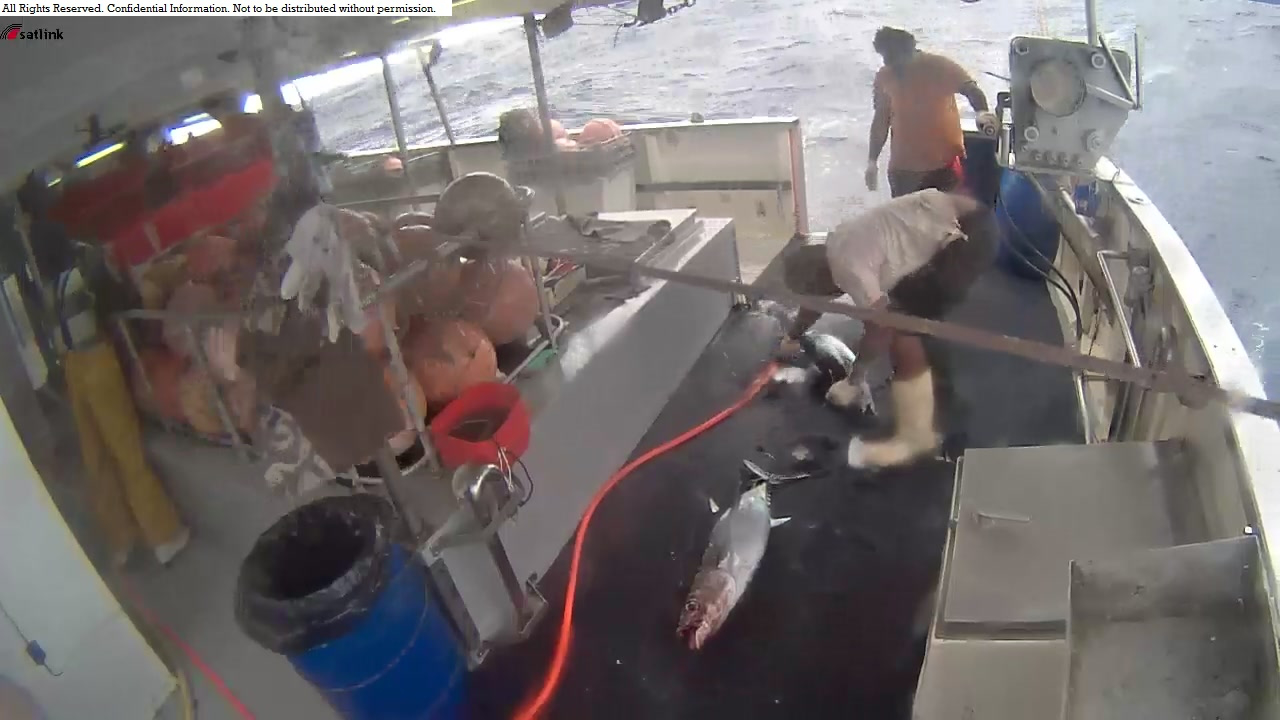

In [5]:
img = load_img(get_random_image_path(VALID_PATH))
print(img.size)
img

### Image preprocessing

### VGG

In [40]:
vgg = VGG19(include_top=False, weights='imagenet',
               input_tensor=None, input_shape=(224,224,3))

vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [41]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(vgg.layers):
    print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [42]:
# first: train only the top layers (which were randomly initialized)
#Let's freeze all layers except last 2
#Let's retrain last two layers
print (len(vgg.layers))
vgg.layers[-3:]

for layer in vgg.layers[:-3]:
     layer.trainable = False
for layer in vgg.layers[-3:]:
    print (layer)
    layer.trainable = True

22


In [43]:
x = vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

# this is the model we will train
model = Model(input=vgg.input, output=predictions)

In [44]:
optimizer = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [45]:
#Load existing weights
weights_filename = WEIGHTS_PATH+'T8S99.weights.15-0.25.hdf5'
model.load_weights(weights_filename)

### Training

In [46]:
BATCH_SIZE = 32

In [47]:
image_generator = ImageDataGenerator()
train_generator = image_generator.flow_from_directory(
        TRAIN_PATH,  # this is the target directory
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='categorical')  # multiclass categorization

valid_generator = image_generator.flow_from_directory(
        VALID_PATH,
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 3022 images belonging to 8 classes.
Found 755 images belonging to 8 classes.


#### Callbacks

In [48]:
#https://keras.io/callbacks/
#https://keras.io/getting-started/faq/ <--- could also save the whole model
prefix = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
weights_filepath = WEIGHTS_PATH+prefix+'.weights.{epoch:02d}-{val_loss:.2f}.hdf5'
weights_saver = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=0, 
                            save_best_only=False, save_weights_only=True, mode='auto', period=1)

In [49]:
#Early stopping, interesting
#https://keras.io/getting-started/faq/#how-can-i-interrupt-training-when-the-validation-loss-isnt-decreasing-anymore
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

In [50]:
model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.nb_sample,
        nb_epoch=16,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample,
        callbacks=[weights_saver])

Epoch 1/16
3022/3022 [==============================] - 59s - loss: 0.2692 - acc: 0.9159 - val_loss: 0.2462 - val_acc: 0.9377

### Predict

In [51]:
#NEED TO MAKE THE UNKNOWN DIR
image_generator = ImageDataGenerator()
test_images = image_generator.flow_from_directory(
        TEST_PATH,
        shuffle=False,
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')  # multiclass categorization

Found 1000 images belonging to 1 classes.


In [52]:
preds = model.predict_generator(test_images, val_samples=test_images.nb_sample)

### Evaluate + Audit

In [53]:
#Run a test on our validation data and see what happens
scores = [model.evaluate_generator(valid_generator, valid_generator.nb_sample) for i in range(1)]
np.round(scores,2)

array([[ 0.23,  0.94]])

In [54]:
audit_preds = model.predict_generator(valid_generator, val_samples=valid_generator.nb_sample)
#validation_labels =

In [55]:
audit_labels = valid_generator.classes
audit_labels = to_categorical(audit_labels) #one-hot encode
print(audit_labels.shape)
print(audit_labels)

(755, 8)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [89]:
def clip_preds(preds):
    return preds.clip(.03,.97)

In [90]:
audit_clipped_preds = clip_preds(audit_preds)

In [91]:
#https://keras.io/losses/
#http://stackoverflow.com/questions/33633370/how-to-print-the-value-of-a-tensor-object-in-tensorflow
#http://stackoverflow.com/questions/35824798/tensorflow-error-using-tf-image-random-numpy-ndarray-object-has-no-attribute
sess = tf.InteractiveSession()
loss = categorical_crossentropy(tf.convert_to_tensor(audit_labels, dtype=np.float32), tf.convert_to_tensor(audit_clipped_preds, dtype=np.float32))
loss.eval()

2.8883843

### Submit

In [92]:
clipped_preds = clip_preds(preds)

In [93]:
def get_filenames():
    filenames = []
    for f in test_images.filenames:
        filenames.append(f[f.find("/")+1:])
    return filenames
test_filenames = get_filenames()
print (test_filenames[:3])

['img_02993.jpg', 'img_04263.jpg', 'img_00551.jpg']


In [94]:
submission = pd.DataFrame(clipped_preds, columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])
submission.insert(0, 'image', test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_02993.jpg,0.030000,0.030000,0.030000,0.030000,0.03,0.030000,0.030000,0.970000
1,img_04263.jpg,0.960744,0.030000,0.030000,0.030000,0.03,0.030000,0.030000,0.030000
2,img_00551.jpg,0.944589,0.030000,0.030000,0.030000,0.03,0.030000,0.030000,0.030000
3,img_04479.jpg,0.151822,0.031745,0.193711,0.045597,0.03,0.227326,0.262072,0.063542
4,img_01392.jpg,0.030000,0.030000,0.030000,0.030000,0.03,0.030000,0.030000,0.970000


In [95]:
submit_file_path = RESULTS_PATH+'submissions.csv'
submission.to_csv(submit_file_path, index=False)

In [96]:
FileLink(submit_file_path)

/home/bfortuner/workplace/data/fisheries/results/submissions.csv